# Homework week 4

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Q1

Revisit the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again (pages 178–179). Compare these two models using both PSIS and WAIC. Which model is expected to make better predictions, according to these criteria? On the basis of the causal model, how should you interpret the parameter estimates from the model preferred by PSIS and WAIC?

## Answer

The DAG is simple, showing marriage as a collider. The data we get is simulated, so we know the relationship has no ambiguity. If we want to understand the effect of age on happiness, we must *not* include marriage. The reverse would be true (want to know effect of marriage, omit age).

 ```
 H --> M < -- A
 ```

In [4]:
# code taken from pymc repo
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

<IPython.core.display.Javascript object>

In [5]:
# code taken from pymc repo
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


<IPython.core.display.Javascript object>

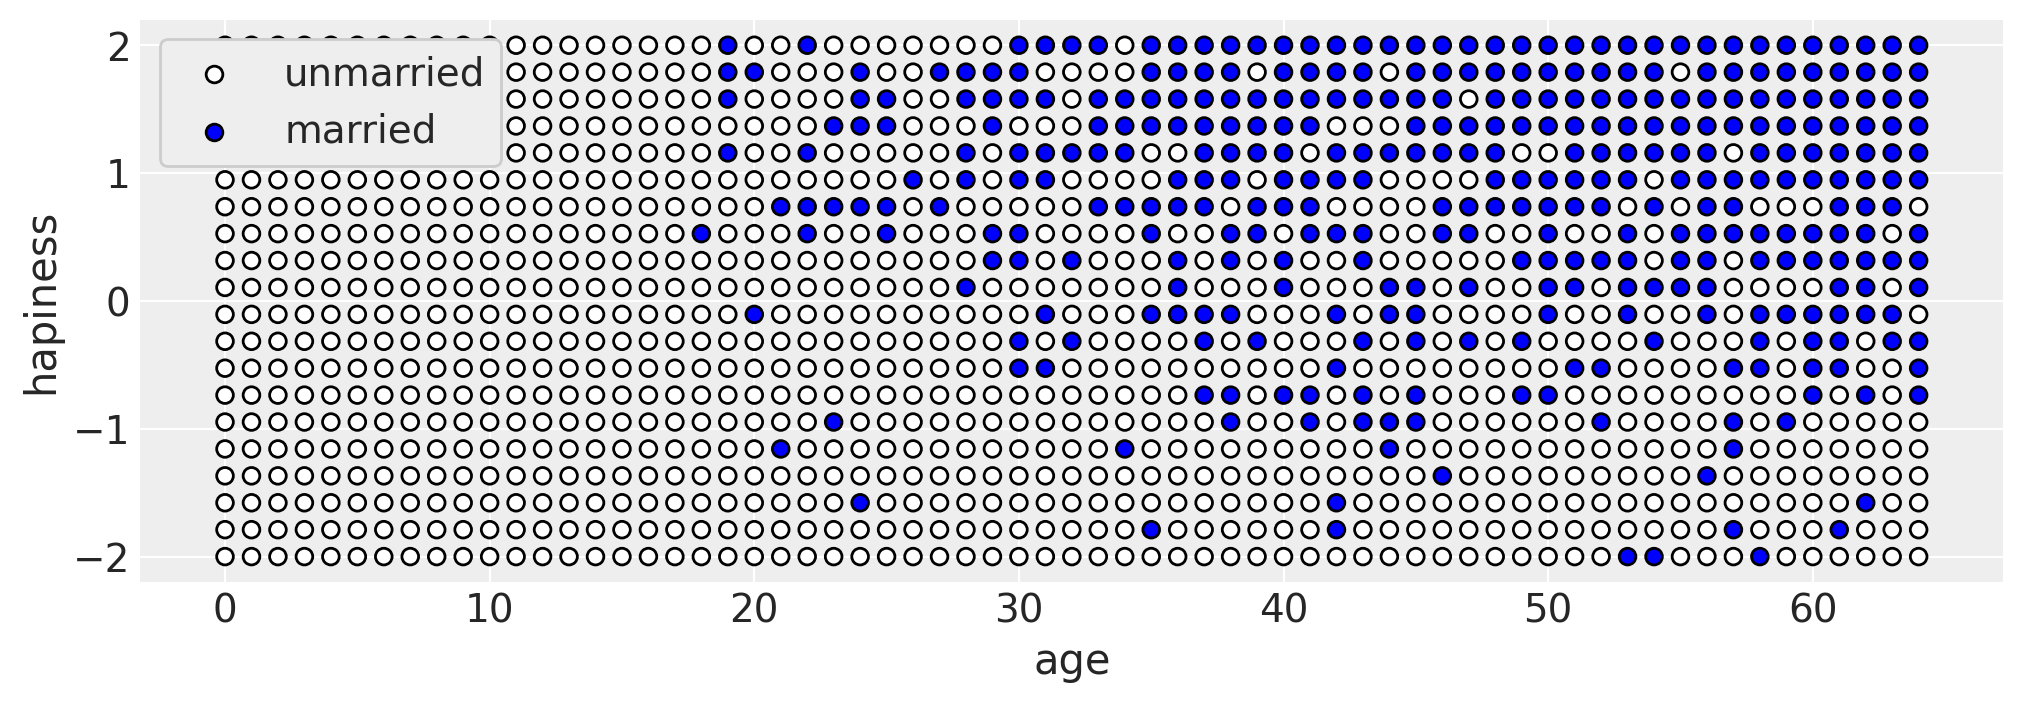

<IPython.core.display.Javascript object>

In [6]:
# code taken from pymc repo
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

In [7]:
# code taken from pymc repo
adults = popn.loc[popn.age > 17]
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<IPython.core.display.Javascript object>

## Model m_6_9: include marriage as a variable

In [8]:
# code taken from pymc repo
mid = pd.Categorical(adults.loc[:, "married"].astype(int))

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.31,-0.09,0.0,0.0,1847.87,1847.87,1855.45,1841.32,1.0
a[1],1.21,0.09,1.07,1.36,0.0,0.0,1762.69,1736.03,1770.84,1754.41,1.0
bA,-0.72,0.12,-0.92,-0.53,0.0,0.0,1637.66,1584.14,1646.09,1643.86,1.0
sigma,1.02,0.02,0.98,1.06,0.0,0.0,2515.56,2509.75,2523.03,2253.98,1.0


<IPython.core.display.Javascript object>

## Model `m_6_10`: omits marriage as a variable

In [9]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8794071043475541, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833985357476417, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.12,0.14,0.0,0.0,1732.69,1333.95,1742.78,1502.90,1.0
bA,-0.00,0.14,-0.23,0.21,0.0,0.0,1697.81,1315.27,1711.93,1596.99,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2395.10,2395.10,2388.11,2330.66,1.0


<IPython.core.display.Javascript object>

In [10]:
az.compare({"marriage": m_6_9_trace, "no marriage": trace_6_10}, ic='loo')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
marriage,0,-1355.468021,3.637306,0.000000,0.979993,18.628344,0.000000,False,log
no marriage,1,-1518.798429,2.426390,163.330408,0.020007,13.663159,16.495425,False,log


<IPython.core.display.Javascript object>

In [11]:
az.compare({"marriage": m_6_9_trace, "no marriage": trace_6_10}, ic='waic')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
marriage,0,-1355.467650,3.636935,0.000000,0.979995,18.628306,0.000000,False,log
no marriage,1,-1518.798473,2.426434,163.330822,0.020005,13.663161,16.495389,False,log


<IPython.core.display.Javascript object>

We can see that both P-LOO and WAIC both show that the model that includes marriage, despite being causally incorrect, shows better predictions (lower LOO and WAIC score). In other words, if we wanted to predict a person's happiness score, we would (counter-intuitively) include both variables.

This problem emphasizes the idea that modeling for pure prediction and modeling for inference can give different results and to be mindful of using scoring criteria (like WAIC) depending on the purpose.

# Q2
Reconsider the urban fox analysis from last week’s homework. On the basis of PSIS and WAIC scores, which combination of variables best predicts body weight (W, weight)? How would you interpret the estimates from the best scoring model?

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


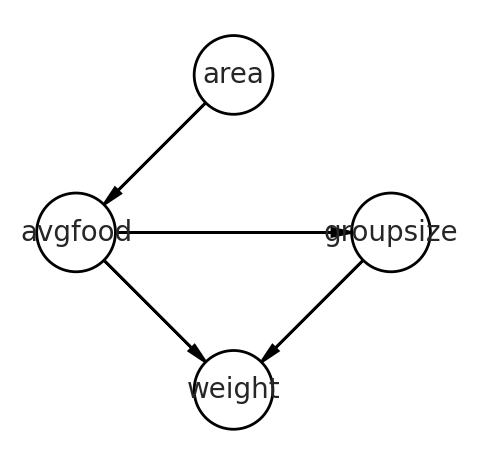

<IPython.core.display.Javascript object>

In [12]:
dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "area": (1, 1),
    "avgfood": (0, 0),
    "groupsize": (2, 0),
    "weight": (1, -1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

## Answer


I'll use the same two models from last week's problem 2 (one with `avgfood` only, one with `avgfood` and `groupsize`), then add a model that includes all 3 predictor variables (`area`, `groupsize`, and `weight`).

I'd hypothesize that the model that includes all variables would have the best predictions even though it is causally incorrect. From a causal perspective, the effect of `area` would be blocked by `avgfood`.


- Build models with a combination of variables
- I'd expect the one with all of them to have the best WAIC/PSIS
- Estimates from best scoring model ... coeffient ... 


In [13]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_foxes = pd.read_csv(DATA_DIR + "foxes.csv", sep=";", header=0)
df_foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


<IPython.core.display.Javascript object>

In [14]:
# standardize variables
df_foxes['area_std'] = standardize(df_foxes['area'])
df_foxes['avgfood_std'] = standardize(df_foxes['avgfood'])
df_foxes['groupsize_std'] = standardize(df_foxes['groupsize'])
df_foxes['weight_std'] = standardize(df_foxes['weight'])
df_foxes.head()

,group,avgfood,groupsize,area,weight,area_std,avgfood_std,groupsize_std,weight_std
0,1,0.37,2,1.09,5.02,-2.249313,-1.933180,-1.530701,0.415931
1,1,0.37,2,1.09,2.84,-2.249313,-1.933180,-1.530701,-1.433238
2,2,0.53,2,2.05,5.33,-1.210738,-1.122886,-1.530701,0.678887
3,2,0.53,2,2.05,6.07,-1.210738,-1.122886,-1.530701,1.306586
4,3,0.49,2,2.12,5.85,-1.135008,-1.325459,-1.530701,1.119973


<IPython.core.display.Javascript object>

In [15]:
with pm.Model() as mq2a:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df_foxes['avgfood_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2a = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2a = pm.sample_posterior_predictive(trace=idata_mq2a, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

In [16]:
with pm.Model() as mq2b:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    bG = pm.Normal("bG", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df_foxes['avgfood_std'] + bG*df_foxes['groupsize_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2b = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2b = pm.sample_posterior_predictive(trace=idata_mq2b, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bG, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8863026045682809, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

In [17]:
with pm.Model() as mq2c:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    bG = pm.Normal("bG", 0, 2)
    bA = pm.Normal("bA", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df_foxes['avgfood_std'] + bG*df_foxes['groupsize_std'] + bA * df_foxes['area_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2c = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2c = pm.sample_posterior_predictive(trace=idata_mq2c, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bG, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7193589895680319, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

## Compare models

In [18]:
az.compare(
    {
        "F": idata_mq2a,
        "F+G": idata_mq2b,
        "F+G+A": idata_mq2c
        }, 
        ic='loo')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
F+G,0,-162.41223,3.948721,0.000000,0.418337,7.989639,0.000000,False,log
F+G+A,1,-162.50756,5.319583,0.095330,0.439900,8.035288,1.776199,False,log
F,2,-167.47909,2.584005,5.066861,0.141763,6.655350,3.950546,False,log


<IPython.core.display.Javascript object>

In [19]:
az.compare(
    {
        "F": idata_mq2a,
        "F+G": idata_mq2b,
        "F+G+A": idata_mq2c
        }, 
        ic='waic')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
F+G,0,-162.390704,3.927195,0.000000,0.411603,7.983641,0.000000,True,log
F+G+A,1,-162.459596,5.271619,0.068892,0.449126,8.021730,1.782317,True,log
F,2,-167.477827,2.582741,5.087123,0.139271,6.655289,3.945037,False,log


<IPython.core.display.Javascript object>

I would've thought that the model with more variables would have the best predictions. It did well, but the F+G model edged it out slightly. What's going on with the coefficients?

Text(0.5, 1.0, 'F+G+A')

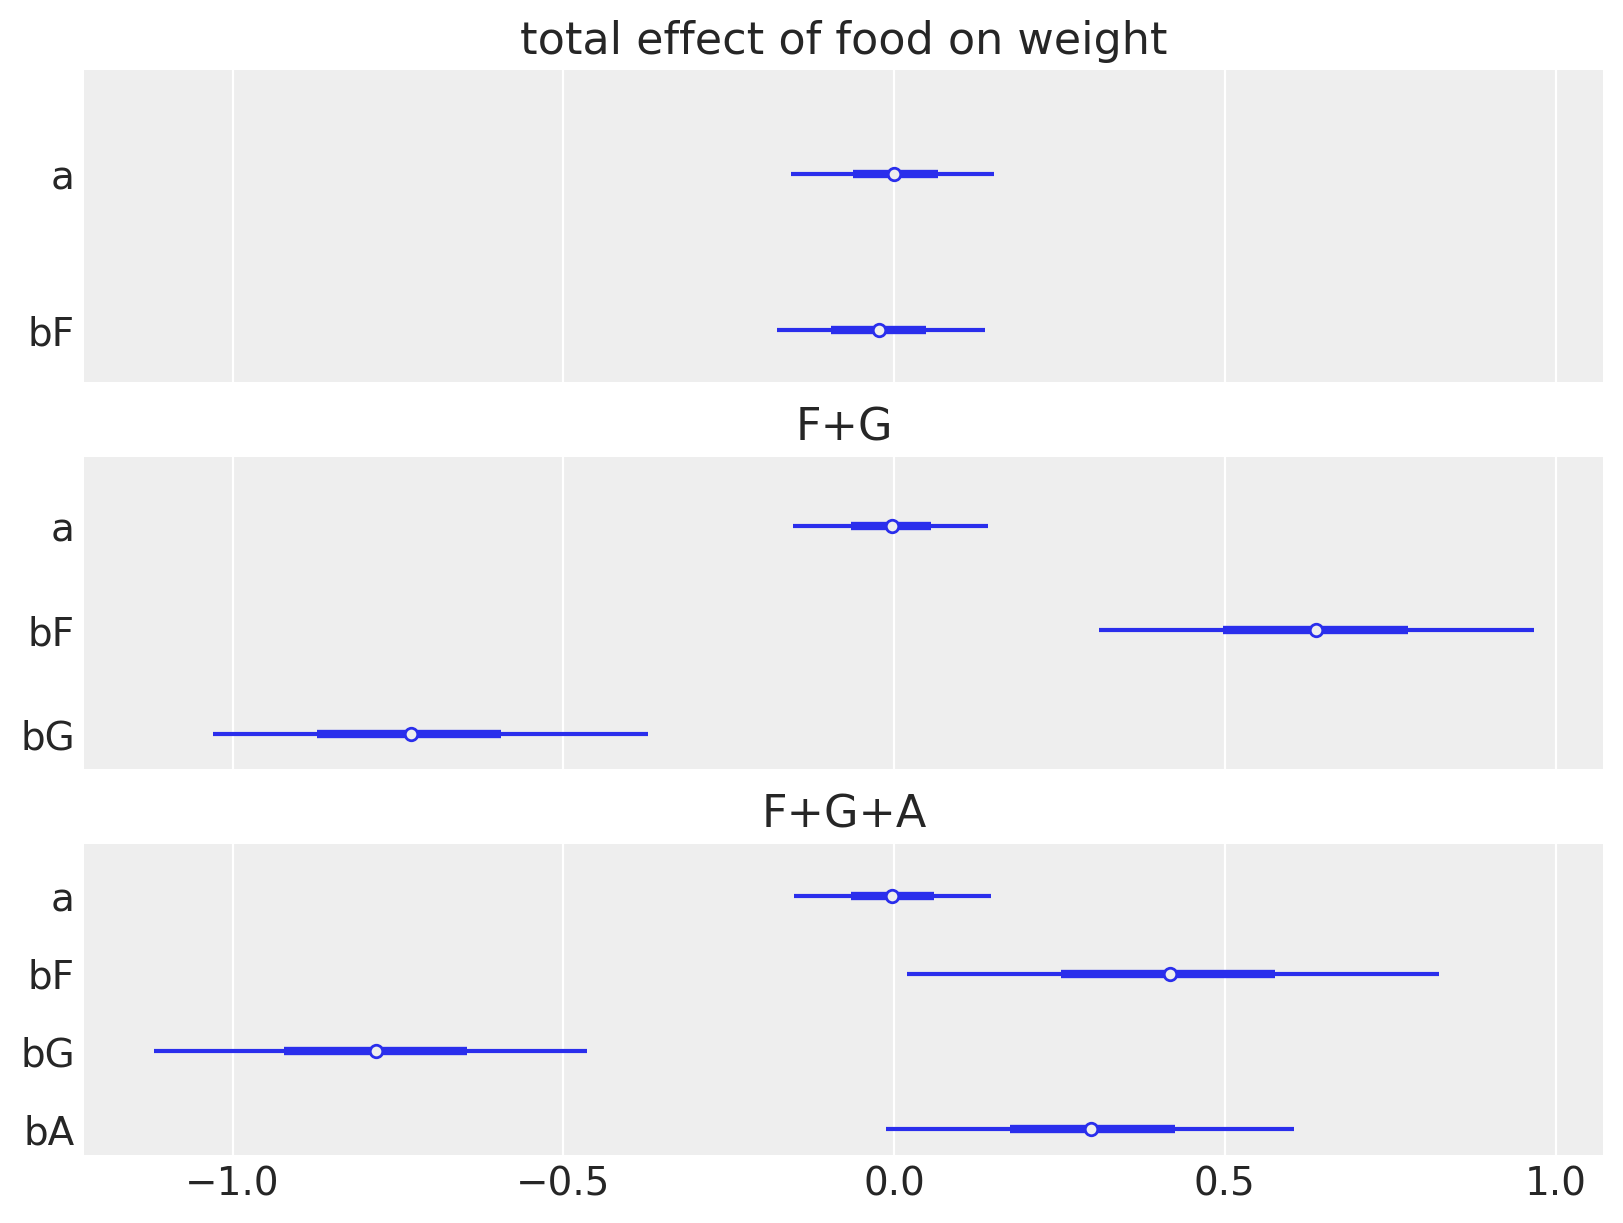

<IPython.core.display.Javascript object>

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
az.plot_forest(idata_mq2a, var_names=['a', 'bF'], combined=True, ax=ax1)
ax1.set_title("total effect of food on weight")

az.plot_forest(idata_mq2b, var_names=['a', 'bF', 'bG'], combined=True, ax=ax2)
ax2.set_title("F+G")

az.plot_forest(idata_mq2c, var_names=['a', 'bF', 'bG', 'bA'], combined=True, ax=ax3)
ax3.set_title("F+G+A")

In [21]:
az.summary(idata_mq2a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.096,-0.156,0.151,0.001,0.002,6132.0,1746.0,6133.0,2924.0,1.0
bF,-0.024,0.100,-0.177,0.137,0.001,0.002,5496.0,2070.0,5456.0,2921.0,1.0
sigma,1.015,0.068,0.902,1.119,0.001,0.001,5251.0,5196.0,5249.0,3009.0,1.0


<IPython.core.display.Javascript object>

In [22]:
az.summary(idata_mq2b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.005,0.092,-0.153,0.143,0.002,0.002,3523.0,1639.0,3537.0,2279.0,1.0
bF,0.633,0.207,0.309,0.968,0.005,0.003,1812.0,1795.0,1817.0,1894.0,1.0
bG,-0.730,0.206,-1.029,-0.372,0.005,0.003,1856.0,1856.0,1862.0,1820.0,1.0
sigma,0.966,0.064,0.864,1.066,0.001,0.001,3406.0,3401.0,3402.0,2501.0,1.0


<IPython.core.display.Javascript object>

In [23]:
az.summary(idata_mq2c)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.092,-0.151,0.146,0.002,0.002,2271.0,1305.0,2268.0,1794.0,1.0
bF,0.417,0.250,0.019,0.824,0.006,0.004,1833.0,1724.0,1832.0,1995.0,1.0
bG,-0.783,0.209,-1.120,-0.465,0.004,0.003,2265.0,2265.0,2272.0,2084.0,1.0
bA,0.297,0.194,-0.012,0.604,0.004,0.003,2335.0,2260.0,2351.0,2024.0,1.0
sigma,0.960,0.067,0.851,1.065,0.001,0.001,2267.0,2267.0,2142.0,1079.0,1.0


<IPython.core.display.Javascript object>

By including A, it reduces some explanation of "F". This could be why the predictions slightly favor the F+G model?

# Q3

Build a predictive model of the relationship show on the cover of the book, the relationship between the timing of cherry blossoms and March temperature in the same year. The data are found in `data(cherry_blossoms)`. Consider at least two functions to predict `doy` with `temp`. Compare them with PSIS or WAIC.

Suppose March temperatures reach 9 degrees by the year 2050. What does your best model predict for the predictive distribution of the day-in-year that the cherry trees will blossom?

## Answer

### Using splines

I'll look back on the splines example in Chapter 4. Note that the "temp" field is the "March temperature" for that year.

Not sure how relevant spline example is.


In [24]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_cb = pd.read_csv(DATA_DIR + "cherry_blossoms.csv", sep=";", header=0)
df_cb.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [25]:
az.summary(df_cb.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
year,1533.395,291.123,1123.00,1978.00
doy,104.921,6.258,95.00,114.00
temp,6.100,0.683,5.00,7.13
temp_upper,6.938,0.812,5.57,7.98
temp_lower,5.264,0.762,4.12,6.40


<IPython.core.display.Javascript object>

In [26]:
df_cb2 = df_cb.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(df_cb2.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

<IPython.core.display.Javascript object>

In [27]:
# spline regression from repo

from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": df_cb2.year.values, "knots": knot_list[1:-1]},
)

<IPython.core.display.Javascript object>

In [28]:
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

<IPython.core.display.Javascript object>

Per the book:
> Each row is a year, corresponding to the rows in the df_cb2 dataframe. Each column is a basis function, one of our synthetic variables defining a span of years within which a corresponding parameter will influence prediction.

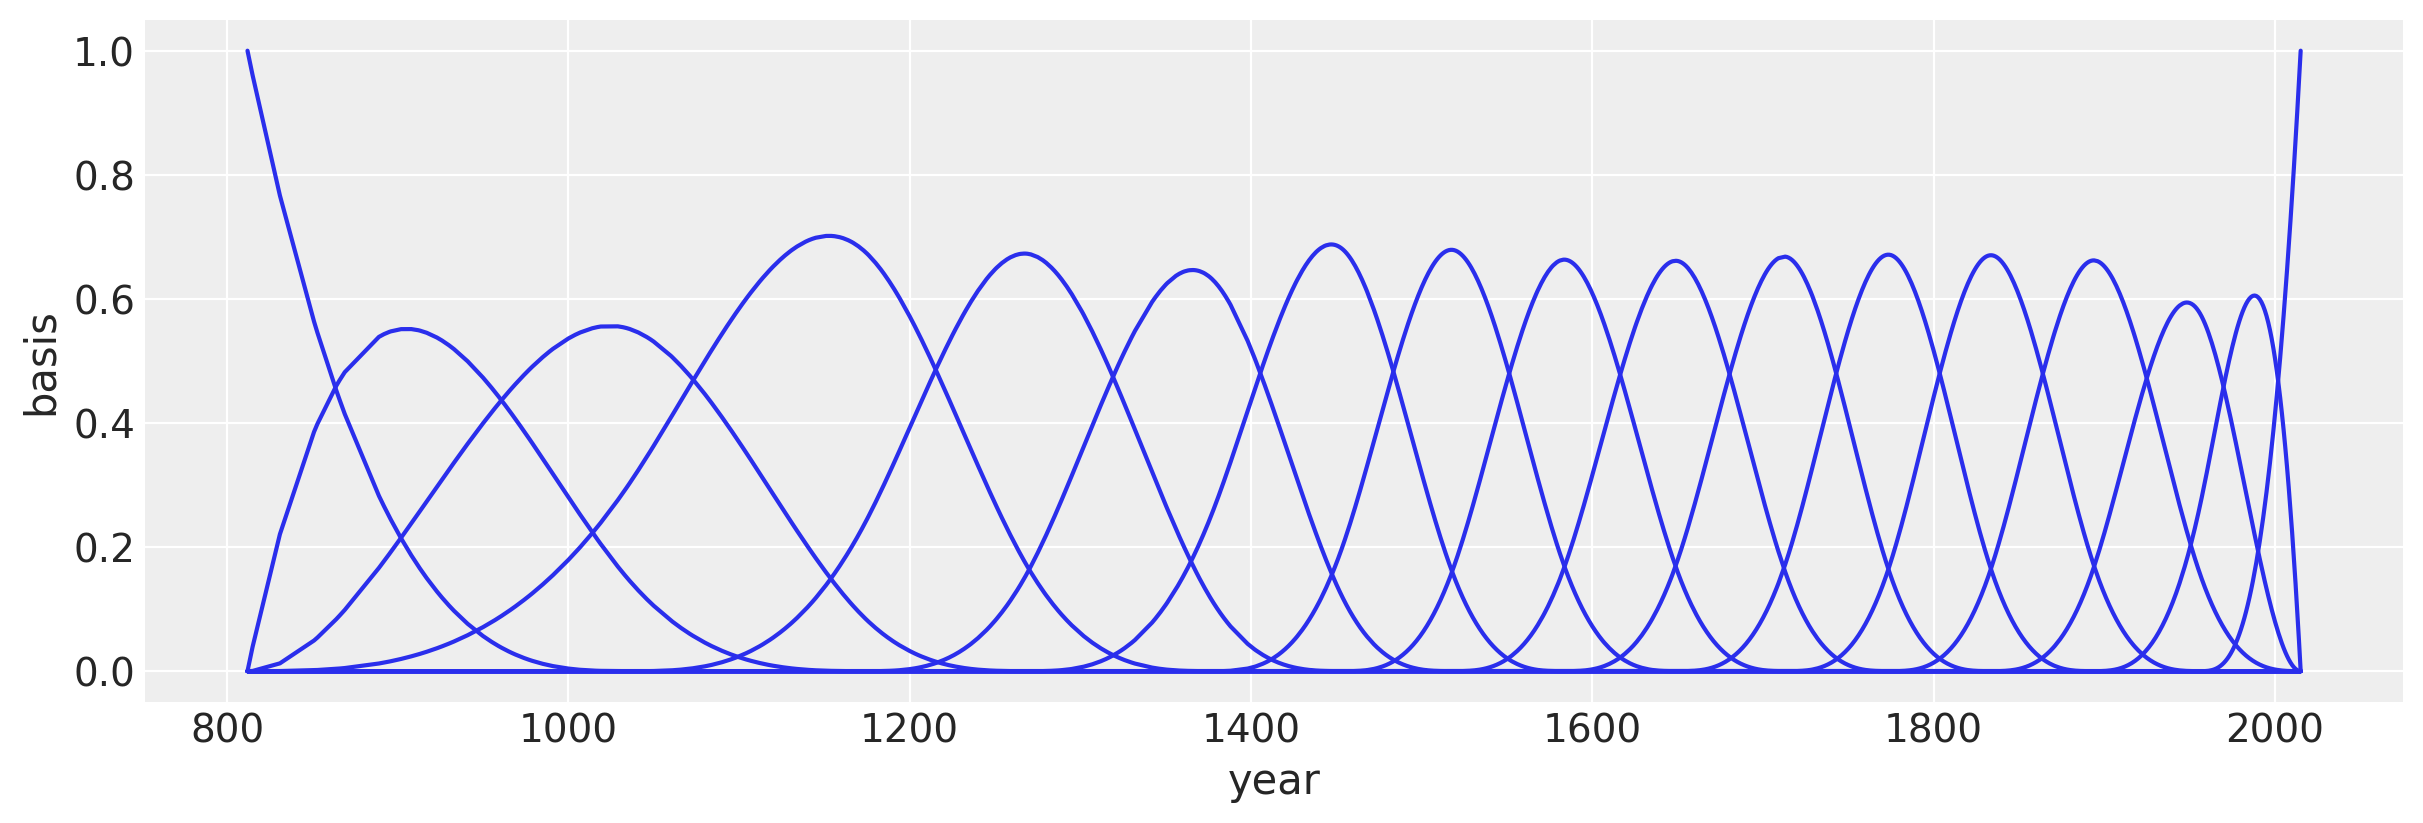

<IPython.core.display.Javascript object>

In [29]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(df_cb2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

In [30]:
df_cb2.head()

,year,doy,temp,temp_upper,temp_lower
11,812,92.0,NaN,NaN,NaN
14,815,105.0,NaN,NaN,NaN
30,831,96.0,NaN,NaN,NaN
50,851,108.0,7.38,12.1,2.66
52,853,104.0,NaN,NaN,NaN


<IPython.core.display.Javascript object>

This is mimicking the spline example although probably not relevant to the question.

In [31]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=df_cb2['doy'])
    trace_m4_7 = pm.sample(1000, target_accept=0.95, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [32]:
az.summary(trace_m4_7)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,103.365,2.311,99.845,107.079,0.102,0.072,513.0,513.0,513.0,894.0,1.0
w[0],-3.049,3.836,-9.057,3.023,0.113,0.080,1151.0,1151.0,1145.0,2356.0,1.0
w[1],-0.841,3.926,-6.996,5.426,0.116,0.082,1155.0,1155.0,1159.0,1820.0,1.0
w[2],-1.102,3.515,-6.617,4.492,0.108,0.076,1059.0,1059.0,1057.0,1715.0,1.0
w[3],4.838,2.879,0.248,9.257,0.107,0.076,719.0,719.0,719.0,1450.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[823],95.797,1.788,92.907,98.571,0.026,0.019,4584.0,4583.0,4584.0,3048.0,1.0
mu[824],95.752,1.939,92.598,98.747,0.029,0.021,4410.0,4408.0,4412.0,3084.0,1.0
mu[825],95.712,2.103,92.433,99.094,0.032,0.023,4255.0,4252.0,4262.0,2889.0,1.0
mu[826],95.675,2.280,92.128,99.365,0.036,0.025,4119.0,4115.0,4125.0,2977.0,1.0


<IPython.core.display.Javascript object>

### Back to problem: predict day of year

#### Model mq3a: using spline, predicting with year

This is mimicking the book example but we need to use the new complete case analysis and account for missing temperature data.

In [33]:
# Do another complete case filtering
df_cb3 = df_cb2.dropna(subset=["temp"])
df_cb3.head()

,year,doy,temp,temp_upper,temp_lower
50,851,108.0,7.38,12.10,2.66
63,864,100.0,6.42,8.69,4.14
65,866,106.0,6.44,8.11,4.77
88,889,104.0,6.83,8.48,5.19
90,891,109.0,6.98,8.96,5.00


<IPython.core.display.Javascript object>

In [34]:
B2 = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": df_cb3.year.values, "knots": knot_list[1:-1]},
)

<IPython.core.display.Javascript object>

In [35]:
with pm.Model() as mq3a:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B2.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B2, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=df_cb3['doy'])
    idata_mq3a = pm.sample(1000, target_accept=0.95, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

#### Model mq2b: linear, predicting with temperature

In [36]:
df_cb3["doy_std"] = standardize(df_cb3["doy"])
df_cb3["temp_std"] = standardize(df_cb3["temp"])
df_cb3["temp_upper_std"] = standardize(df_cb3["temp_upper"])
df_cb3["temp_lower_std"] = standardize(df_cb3["temp_lower"])
df_cb3.head()

<ipython-input-36-26b74078ff99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cb3["doy_std"] = standardize(df_cb3["doy"])
<ipython-input-36-26b74078ff99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cb3["temp_std"] = standardize(df_cb3["temp"])
<ipython-input-36-26b74078ff99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,year,doy,temp,temp_upper,temp_lower,doy_std,temp_std,temp_upper_std,temp_lower_std
50,851,108.0,7.38,12.10,2.66,0.492309,1.873630,6.361833,-3.418027
63,864,100.0,6.42,8.69,4.14,-0.786923,0.468017,2.159585,-1.475030
65,866,106.0,6.44,8.11,4.77,0.172501,0.497300,1.444833,-0.647944
88,889,104.0,6.83,8.48,5.19,-0.147307,1.068331,1.900796,-0.096553
90,891,109.0,6.98,8.96,5.00,0.652213,1.287958,2.492315,-0.345991


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'temp (std)'),
 Text(0, 0.5, 'doy (std)'),
 Text(0.5, 1.0, 'standardized')]

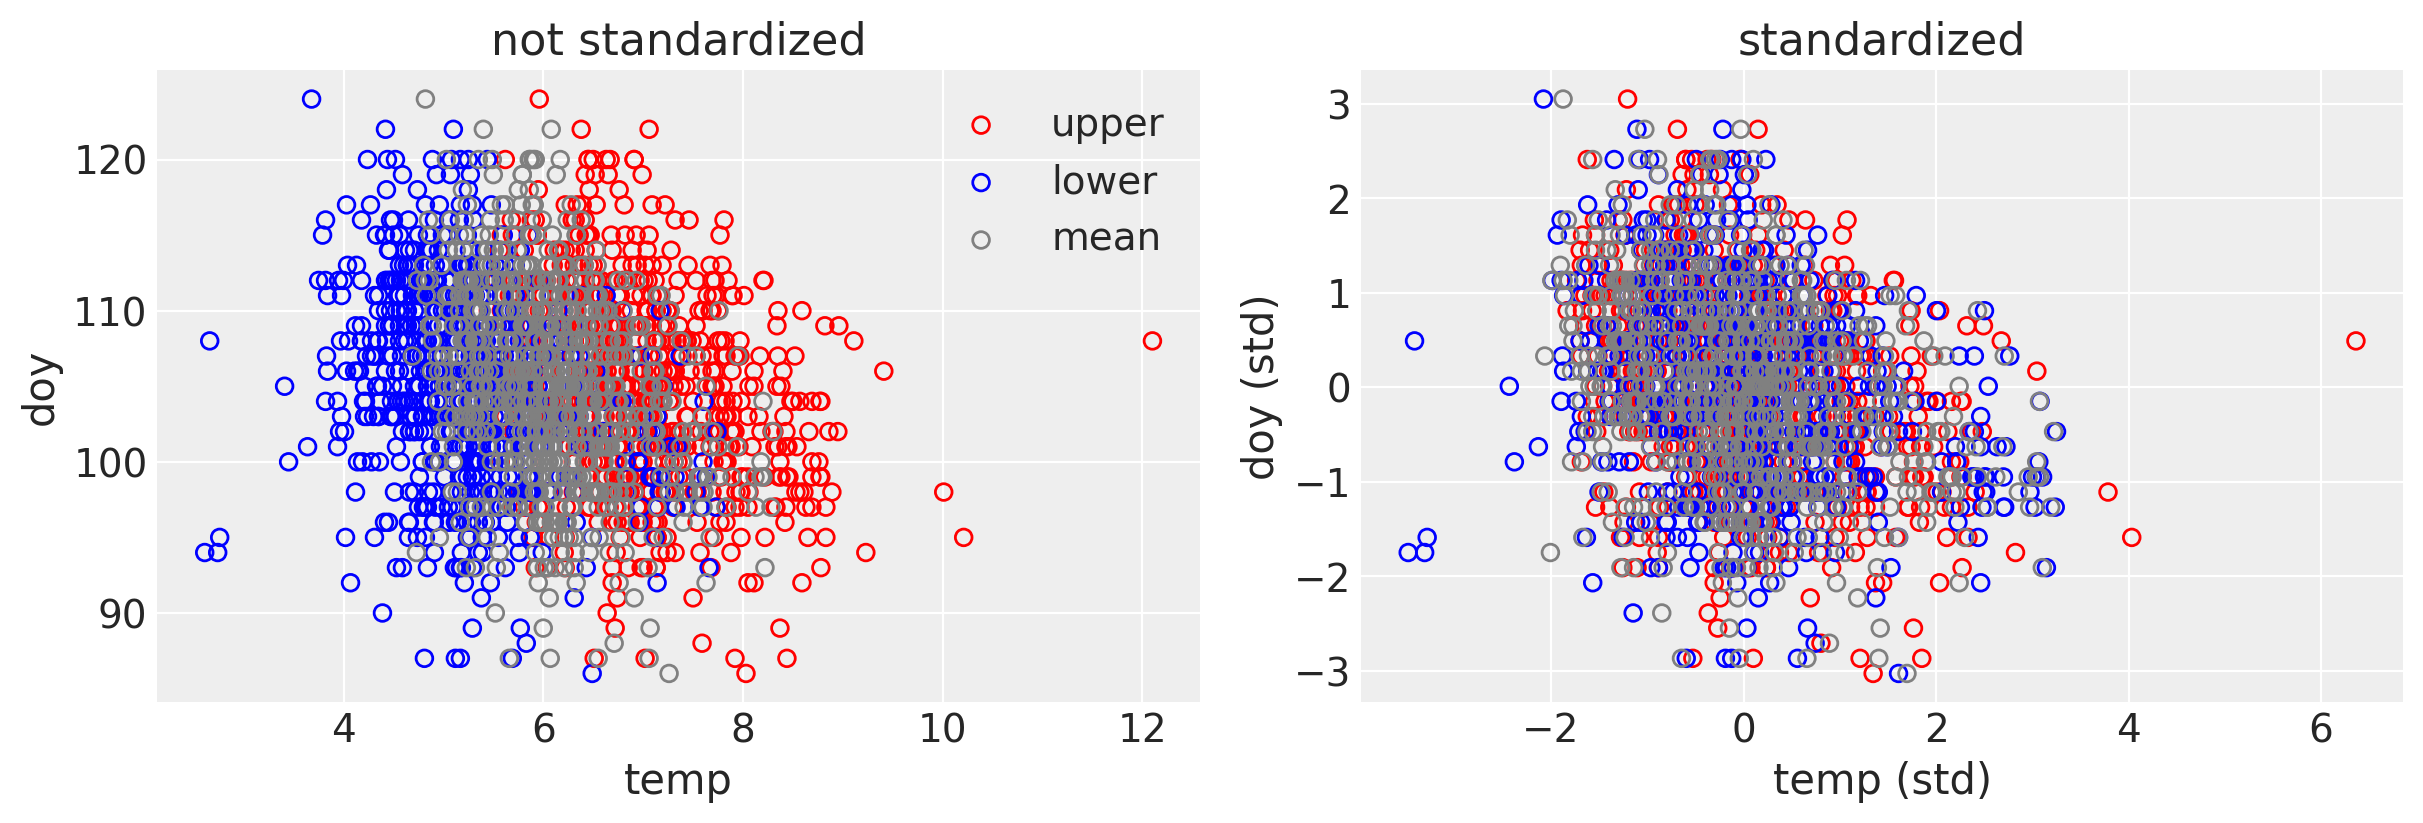

<IPython.core.display.Javascript object>

In [37]:
# predict day of year with temperature
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_cb3['temp_upper'], df_cb3['doy'], label='upper', facecolors='none', edgecolor='red')
ax1.scatter(df_cb3['temp_lower'], df_cb3['doy'], label='lower', facecolors='none', edgecolor='blue')
ax1.scatter(df_cb3['temp'], df_cb3['doy'], label='mean', facecolors='none', edgecolor='gray')
ax1.set(xlabel='temp', ylabel='doy', title="not standardized")
ax1.legend()

ax2.scatter(df_cb3['temp_upper_std'], df_cb3['doy_std'], facecolors='none', edgecolor='red')
ax2.scatter(df_cb3['temp_lower_std'], df_cb3['doy_std'], facecolors='none', edgecolor='blue')
ax2.scatter(df_cb3['temp_std'], df_cb3['doy_std'], facecolors='none', edgecolor='gray')
ax2.set(xlabel='temp (std)', ylabel='doy (std)', title="standardized")


The first model I can build is a simple linear regression using only `temp` to predict `doy`.

First we'll standardize, noting the standard deviations so we can re-scale back.

But need to use the basis function for the last example. I'll just guess.

In [38]:
with pm.Model() as mq3b:

    # priors
    a = pm.Normal("a", 100, 10)
    bT = pm.Normal("bT", 5, 3)
    sigma = pm.Exponential("sigma", 2)

    # linear model
    mu = a + bT*df_cb3['temp']

    # likelihood
    D = pm.Normal("D", mu, sigma, observed=df_cb3['doy'])

    # posterior
    idata_mq3b = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [39]:
az.summary(idata_mq3b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,121.895,1.847,118.886,124.838,0.048,0.034,1462.0,1462.0,1473.0,1504.0,1.0
bT,-2.784,0.303,-3.281,-2.308,0.008,0.006,1453.0,1453.0,1462.0,1411.0,1.0
sigma,5.885,0.148,5.643,6.116,0.003,0.002,1985.0,1983.0,1986.0,1769.0,1.0


<IPython.core.display.Javascript object>

#### Model mq3c: spline and temperature

In [40]:
with pm.Model() as mq3c:
    # priors
    a = pm.Normal("a", 100, 10)
    bT = pm.Normal("bT", 5, 3)
    sigma = pm.Exponential("sigma", 1)

    # spline weights
    w = pm.Normal("w", mu=0, sd=10, shape=B2.shape[1])

    # linear model
    mu = pm.Deterministic("mu", a + bT*df_cb3['temp'] + pm.math.dot(np.asarray(B2, order="F"), w.T))
    
    D = pm.Normal("D", mu, sigma, observed=df_cb3['doy'])
    idata_mq3c = pm.sample(1000, target_accept=0.95, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma, bT, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [41]:
az.summary(idata_mq3c, var_names=["a", "bT", "w", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,117.787,3.961,111.343,123.924,0.118,0.083,1130.0,1126.0,1130.0,1989.0,1.0
bT,-2.279,0.534,-3.152,-1.459,0.011,0.008,2338.0,2326.0,2363.0,2509.0,1.0
w[0],4.374,4.044,-2.187,10.752,0.114,0.081,1261.0,1261.0,1263.0,2010.0,1.0
w[1],-1.997,3.903,-8.010,4.395,0.112,0.079,1220.0,1220.0,1217.0,1988.0,1.0
w[2],0.489,3.580,-4.922,6.343,0.113,0.080,1007.0,1007.0,1014.0,1983.0,1.0
w[3],2.429,2.958,-2.104,7.394,0.102,0.072,844.0,844.0,844.0,1327.0,1.0
w[4],-0.280,2.930,-5.074,4.276,0.103,0.073,806.0,806.0,806.0,1730.0,1.0
w[5],3.164,2.928,-1.576,7.752,0.104,0.074,794.0,794.0,794.0,1269.0,1.0
w[6],-2.684,2.952,-7.292,2.075,0.103,0.073,816.0,816.0,816.0,1627.0,1.0
w[7],2.836,2.994,-2.181,7.345,0.110,0.078,742.0,742.0,744.0,1551.0,1.0


<IPython.core.display.Javascript object>

#### Model mq3d: spline/temp and regular term with temp (thanks Rojan)

In [47]:
df_cb3.head()

,year,doy,temp,temp_upper,temp_lower,doy_std,temp_std,temp_upper_std,temp_lower_std
50,851,108.0,7.38,12.10,2.66,0.492309,1.873630,6.361833,-3.418027
63,864,100.0,6.42,8.69,4.14,-0.786923,0.468017,2.159585,-1.475030
65,866,106.0,6.44,8.11,4.77,0.172501,0.497300,1.444833,-0.647944
88,889,104.0,6.83,8.48,5.19,-0.147307,1.068331,1.900796,-0.096553
90,891,109.0,6.98,8.96,5.00,0.652213,1.287958,2.492315,-0.345991


<IPython.core.display.Javascript object>

In [71]:
num_knots=30
knot_list=np.quantile(df_cb3.temp,np.linspace(0,1,num_knots))

B3 = dmatrix(
    "bs(temp, knots=knots, degree=3, include_intercept=True) - 1",
    {"temp": df_cb3.temp.values, "knots": knot_list[1:-1]},
)

<IPython.core.display.Javascript object>

In [72]:
with pm.Model() as mq3d:
    # priors
    a = pm.Normal("a", 100, 10)
    bT = pm.Normal("bT", 5, 3)
    sigma = pm.Exponential("sigma", 1)

    # spline weights
    w = pm.Normal("w", mu=0, sd=10, shape=B3.shape[1])

    # linear model
    mu = pm.Deterministic("mu", a + bT*df_cb3['temp'] + pm.math.dot(np.asarray(B3, order="F"), w.T))
    
    D = pm.Normal("D", mu, sigma, observed=df_cb3['doy'])
    idata_mq3d = pm.sample(1000, target_accept=0.95, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma, bT, a]
INFO:pymc3:NUTS: [w, sigma, bT, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


<IPython.core.display.Javascript object>

In [73]:
az.summary(idata_mq3d, var_names=["a", "bT", "w", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,103.311,7.383,92.299,116.072,0.198,0.140,1396.0,1396.0,1388.0,1978.0,1.0
bT,0.228,1.207,-1.668,2.207,0.031,0.022,1485.0,1485.0,1485.0,1838.0,1.0
w[0],0.710,4.632,-6.467,8.267,0.095,0.067,2397.0,2397.0,2394.0,3219.0,1.0
w[1],10.376,5.025,2.496,18.440,0.107,0.076,2201.0,2201.0,2205.0,2430.0,1.0
w[2],-0.455,4.329,-7.087,6.672,0.087,0.067,2453.0,2106.0,2460.0,2500.0,1.0
w[3],3.891,3.031,-0.699,8.971,0.081,0.057,1398.0,1398.0,1398.0,2214.0,1.0
w[4],3.830,2.774,-0.460,8.376,0.068,0.048,1651.0,1651.0,1656.0,2466.0,1.0
w[5],-0.564,2.972,-5.335,4.136,0.078,0.055,1437.0,1437.0,1434.0,2514.0,1.0
w[6],5.487,3.008,0.725,10.336,0.070,0.049,1862.0,1862.0,1866.0,2479.0,1.0
w[7],0.365,3.051,-4.724,5.069,0.079,0.056,1504.0,1504.0,1503.0,2525.0,1.0


<IPython.core.display.Javascript object>

#### Model comparison

In [74]:
az.compare({"year (spline) only": idata_mq3a, "temp only":idata_mq3b , "spline (year) and temp":idata_mq3c, "spline (temp) and temp":idata_mq3d}, ic='waic')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
temp only,0,-2518.095658,2.852920,0.000000,8.910633e-01,20.610757,0.000000,False,log
spline (year) and temp,1,-2527.535532,16.960362,9.439874,2.391993e-15,20.391880,3.371669,False,log
spline (temp) and temp,2,-2529.697232,29.894353,11.601574,1.089367e-01,20.506260,5.401005,True,log
year (spline) only,3,-2537.563112,15.701213,19.467454,8.881784e-16,20.505712,5.686782,False,log


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Log'>

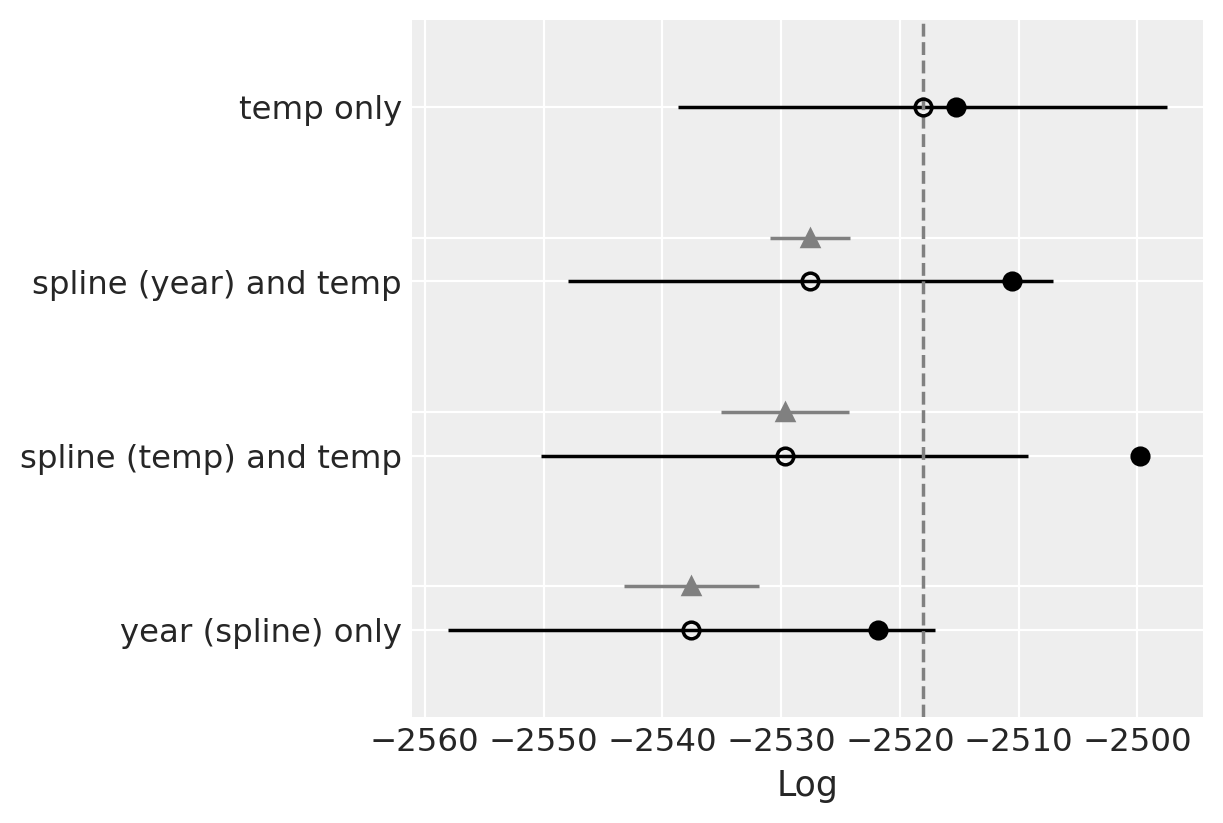

<IPython.core.display.Javascript object>

In [75]:
 df_compare = az.compare({"year (spline) only": idata_mq3a, "temp only":idata_mq3b , "spline (year) and temp":idata_mq3c, "spline (temp) and temp":idata_mq3d}, ic='waic')
 az.plot_compare(df_compare)

### Prediction in year 2050

In [76]:
az.summary(idata_mq3b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,121.895,1.847,118.886,124.838,0.048,0.034,1462.0,1462.0,1473.0,1504.0,1.0
bT,-2.784,0.303,-3.281,-2.308,0.008,0.006,1453.0,1453.0,1462.0,1411.0,1.0
sigma,5.885,0.148,5.643,6.116,0.003,0.002,1985.0,1983.0,1986.0,1769.0,1.0


<IPython.core.display.Javascript object>

In [77]:
idata_mq3b_df = idata_mq3b.to_dataframe()
idata_mq3b_df.head()

,chain,draw,"(posterior, a)","(posterior, bT)","(posterior, sigma)","(log_likelihood, D[0], 0)","(log_likelihood, D[100], 100)","(log_likelihood, D[101], 101)","(log_likelihood, D[102], 102)","(log_likelihood, D[103], 103)",...,"(sample_stats, perf_counter_diff)","(sample_stats, step_size_bar)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, step_size)","(sample_stats, perf_counter_start)","(sample_stats, lp)","(sample_stats, mean_tree_accept)","(sample_stats, tree_size)","(sample_stats, energy_error)"
0,0,0,117.818420,-2.168764,6.190586,-3.241399,-3.845347,-6.018331,-2.889907,-3.127713,...,0.003083,0.121838,1.711467,5,0.115925,202.582584,-2540.514172,0.651555,31.0,0.827497
1,0,1,117.744120,-2.128140,6.198769,-3.205753,-3.882902,-6.073138,-2.903379,-3.108937,...,0.001574,0.121838,-0.606012,4,0.115925,202.585800,-2540.018403,0.960852,15.0,-0.484742
2,0,2,120.776501,-2.588479,6.044718,-3.265822,-4.008734,-6.438261,-2.949202,-3.014990,...,0.001570,0.121838,0.200587,4,0.115925,202.587494,-2536.383610,0.939639,15.0,-0.077429
3,0,3,119.506316,-2.376648,6.203195,-3.216998,-3.960108,-6.233393,-2.947522,-3.046947,...,0.001532,0.121838,0.084001,4,0.115925,202.589182,-2538.659480,0.971046,15.0,0.045140
4,0,4,120.411312,-2.583957,5.905620,-3.330414,-3.954253,-6.433104,-2.898391,-3.053169,...,0.001720,0.121838,1.713076,4,0.115925,202.590854,-2536.510699,0.749039,13.0,0.225985


<IPython.core.display.Javascript object>

In [80]:
temp_2050 = 9
pred_mean = idata_mq3b_df[('posterior', 'a')] + idata_mq3b_df[('posterior', 'bT')]*temp_2050
pred_obs = stats.norm.rvs(pred_mean, idata_mq3b_df[('posterior', 'sigma')])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Predicted doy in year 2050 ')

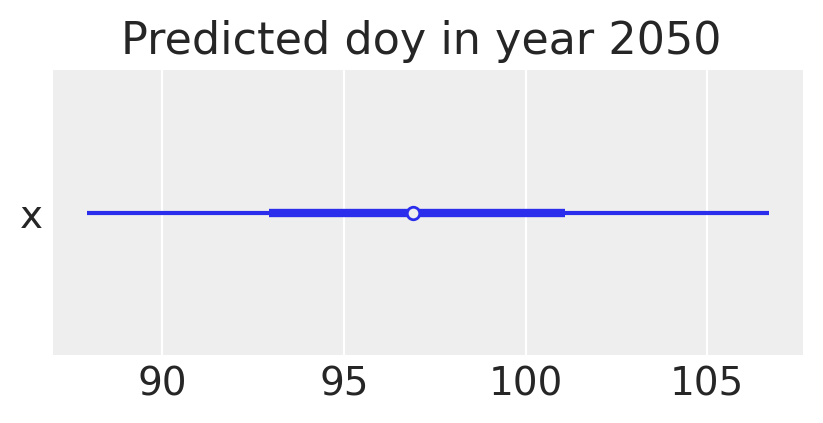

<IPython.core.display.Javascript object>

In [81]:
f, ax1 = plt.subplots(figsize=(4, 2))
az.plot_forest(pred_obs, ax=ax1)
ax1.set_title('Predicted doy in year 2050 ')

In [83]:
az.summary(pred_obs)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,96.964,5.968,87.92,106.706,0.108,0.076,3077.0,3077.0,3081.0,3608.0,NaN


<IPython.core.display.Javascript object>

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


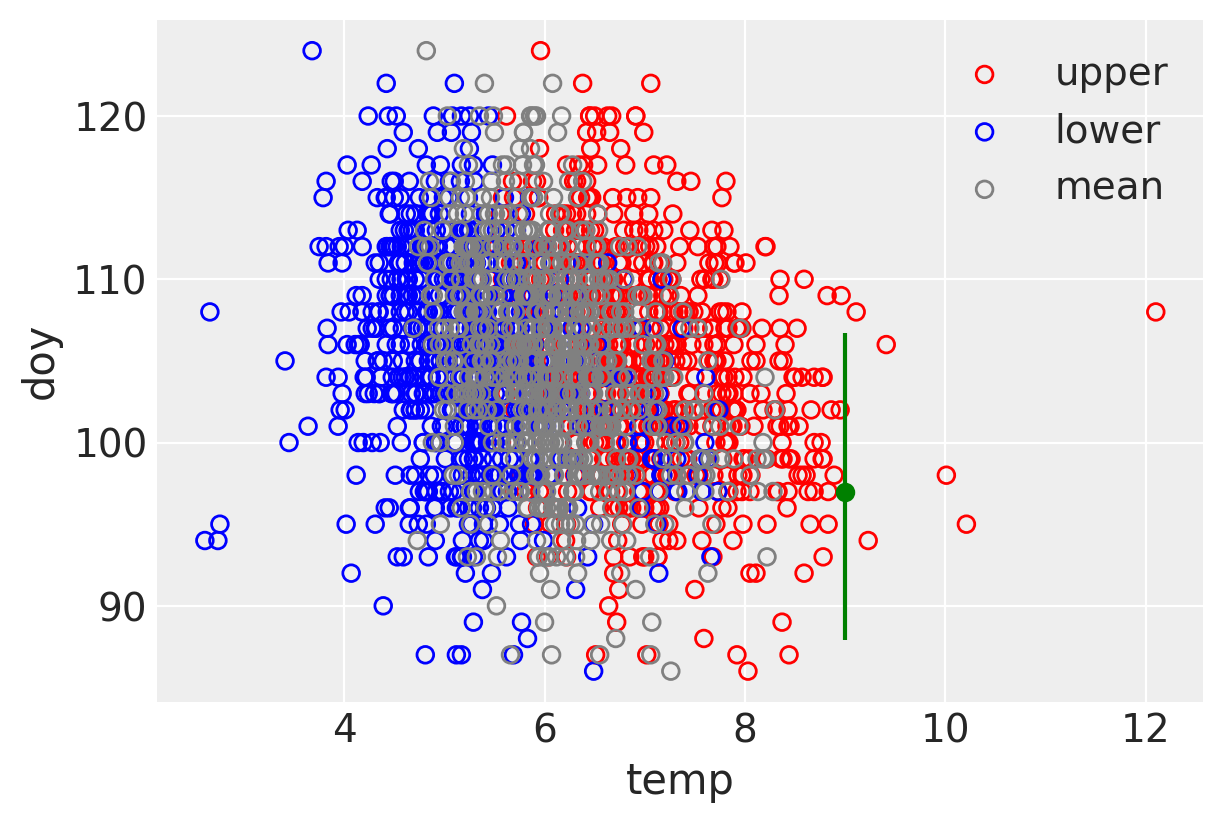

<IPython.core.display.Javascript object>

In [86]:
# predict day of year with temperature
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
ax1.scatter(df_cb3['temp_upper'], df_cb3['doy'], label='upper', facecolors='none', edgecolor='red')
ax1.scatter(df_cb3['temp_lower'], df_cb3['doy'], label='lower', facecolors='none', edgecolor='blue')
ax1.scatter(df_cb3['temp'], df_cb3['doy'], label='mean', facecolors='none', edgecolor='gray')
ax1.set(xlabel='temp', ylabel='doy')
ax1.legend()

ax1.scatter(temp_2050, az.summary(pred_obs)['mean'], color='green')
ax1.vlines(x=temp_2050, ymin=az.summary(pred_obs)['hdi_5.5%'], ymax=az.summary(pred_obs)['hdi_94.5%'], color='green')

# Q4 (optional)

The data in `data(Dinosaurs)` are body mass estimates at different estimated ages for six different dinosaur species. See ?Dinosaurs for more details. Choose one or more of these species (at least one, but as many as you like) and model its growth. To be precise: Make a predictive model of body mass using age as a predictor. Consider two or more model types for the function relating age to body mass and score each using PSIS and WAIC.

Which model do you think is best, on predictive grounds? On scientific grounds? If your answers to these questions differ, why?

This is a challenging exercise, because the data are so scarce. But it is also a realistic example, because people publish Nature papers with even less data. So do your best, and I look forward to seeing your growth curves.

## Answer

- This is similar to the Oxford bonus example a couple of weeks ago.

In [43]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_dinosaurs = pd.read_csv(DATA_DIR + "Dinosaurs.csv", sep=";", header=0)
df_dinosaurs.head()

,age,mass,species,sp_id
0,1,162.7,Maiasaura peeblesorum,2
1,5,423.1,Maiasaura peeblesorum,2
2,6,1429.0,Maiasaura peeblesorum,2
3,1,0.5,Shuvuuia deserti,5
4,2,0.6,Shuvuuia deserti,5


<IPython.core.display.Javascript object>

In [44]:
df_dinosaurs['species'].value_counts()

Massospondylus carinatus       9
Psittacosaurus mongoliensis    7
Syntarsus rhodesiensis         6
Apatosaurus excelsus           4
Shuvuuia deserti               3
Maiasaura peeblesorum          3
Name: species, dtype: int64

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [45]:
%watermark -n -u -v -iv -w

Last updated: Wed Feb 02 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib : 3.3.4
arviz      : 0.11.1
daft       : 0.1.0
numpy      : 1.20.1
pandas     : 1.2.1
scipy      : 1.6.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pymc3      : 3.11.0
statsmodels: 0.12.2
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>